<a href="https://colab.research.google.com/github/Present-Jeong/Hyunjae-Yeah-/blob/master/diabetic%20retinopathy%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 
### *cool imports*

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline
from tqdm import tqdm
import numpy as np

# 2.
#preobservation of the train set

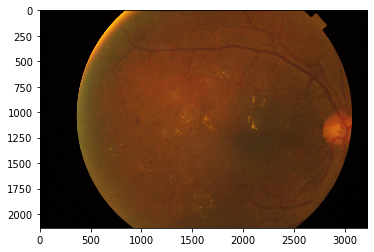

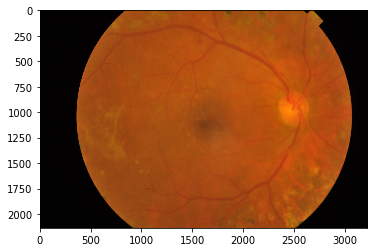

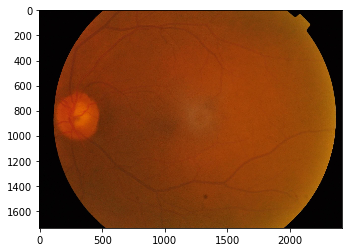

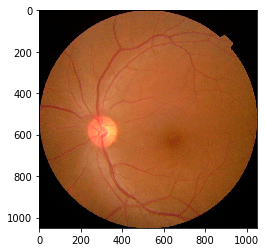

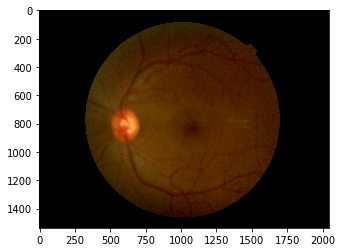

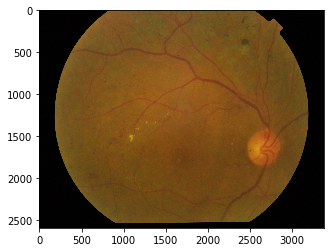

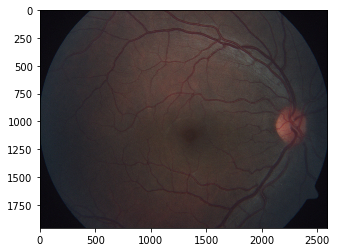

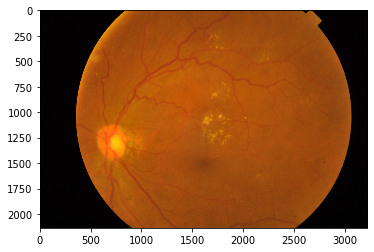

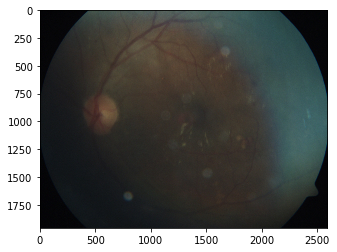

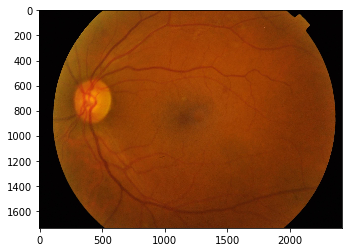

In [ ]:
train = pd.read_csv('./drive/My Drive/Colab Notebooks/train.csv')
df = train['id_code']
for i in df[0:10]:
    img = mpimg.imread('./drive/My Drive/Colab Notebooks/train_images/{0}.png'.format(i))
    img = cv2.imread('./train_images/{0}.png'.format(i), cv2.IMREAD_UNCHANGED)
    plt.imshow(img)
    plt.show()
    cv2.imwrite('gray', image)
    cv2.imshow('gray',image)
#     
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#3.
# preobservation of the test set

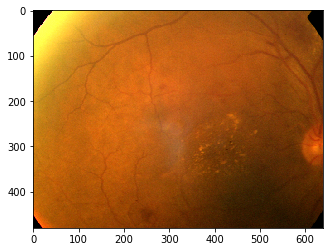

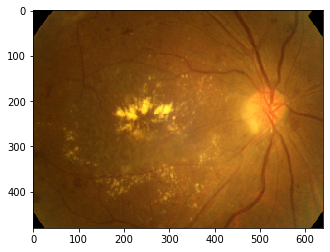

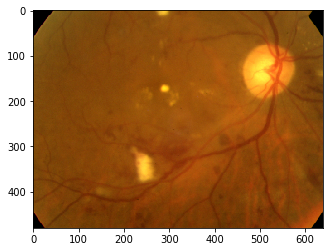

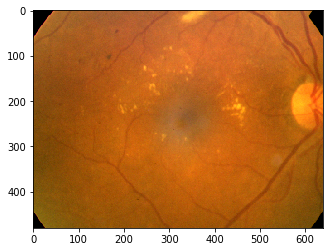

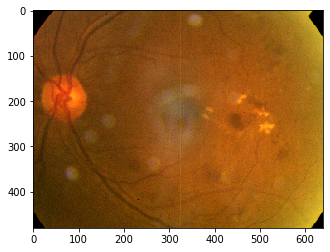

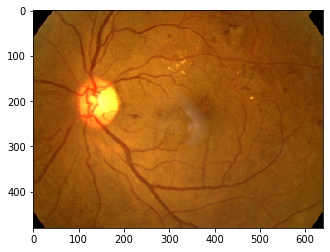

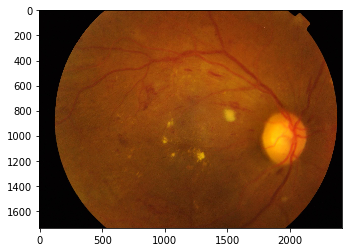

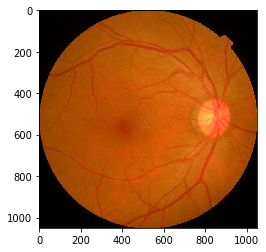

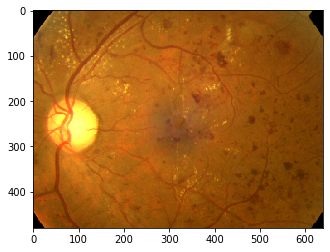

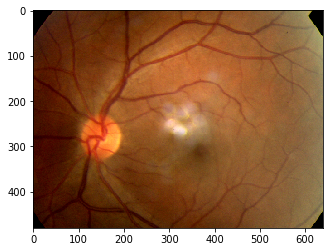

In [ ]:
test = pd.read_csv('./drive/My Drive/Colab Notebooks/test.csv')
df2 = test['id_code']
for i in df2[0:10]:
    img = mpimg.imread('./drive/My Drive/Colab Notebooks/test_images/{0}.png'.format(i))
    img = cv2.imread('./train_images/{0}.png'.format(i), cv2.IMREAD_UNCHANGED)
    plt.imshow(img)
    plt.show()
    cv2.imwrite('gray', image)
    cv2.imshow('gray',image)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# 4.
# showing id_code of 10 data sets

In [ ]:
df[0:10]

0    000c1434d8d7
1    001639a390f0
2    0024cdab0c1e
3    002c21358ce6
4    005b95c28852
5    0083ee8054ee
6    0097f532ac9f
7    00a8624548a9
8    00b74780d31d
9    00cb6555d108
Name: id_code, dtype: object

id_code랑 이미지의 id_code랑 맞는지 확인

In [ ]:
from sklearn.model_selection import train_test_split
df = train['id_code']
df2 = train['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(df,df2,test_size=0.2)
len(x_train), len(x_test), len(y_train), len(y_test)

(2929, 733, 2929, 733)

뒤에서 split할 때 8:2로 했을 때 각각의 data 수 알기 위해 해봄

#5.
#preprocessing

In [ ]:
class RetinopathyData(Dataset):
    def __init__(self,csv_file,transform):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        img_name = os.path.join('./drive/My Drive/Colab Notebooks/train_images', self.data.loc[idx,'id_code'] + '.png')
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        IMG_SIZE = 224
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
        image=Image.fromarray(
                          cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                         ) 
        image = self.transform(image)
# 왜 그냥 image하면 안되고 cv2.cvt... 을 해줘야되는걸까
        label = torch.tensor(self.data.loc[idx,'diagnosis'])
        return {'image': image,
                'labels': label}
# tensor가 정확하게 뭘까? 왜 train_dataset[3200]은 다 0이나오는걸까

In [ ]:
df = train['id_code']
for i in enumerate(df):
  img_name = os.path.join('./drive/My Drive/Colab Notebooks/train_images/{0}.png').format(i)        
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  IMG_SIZE = 224
  image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
  image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
  cv2.imwrite('./drive/My Drive/Colab Notebooks/preprocessing/{0}.png').format(i)
  cv2.waitkey(0.1)
  cv2.destroyAllWindows()


#6.
#visualizing the distribution of the data sets & observing 25 test image

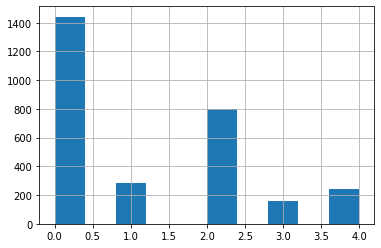

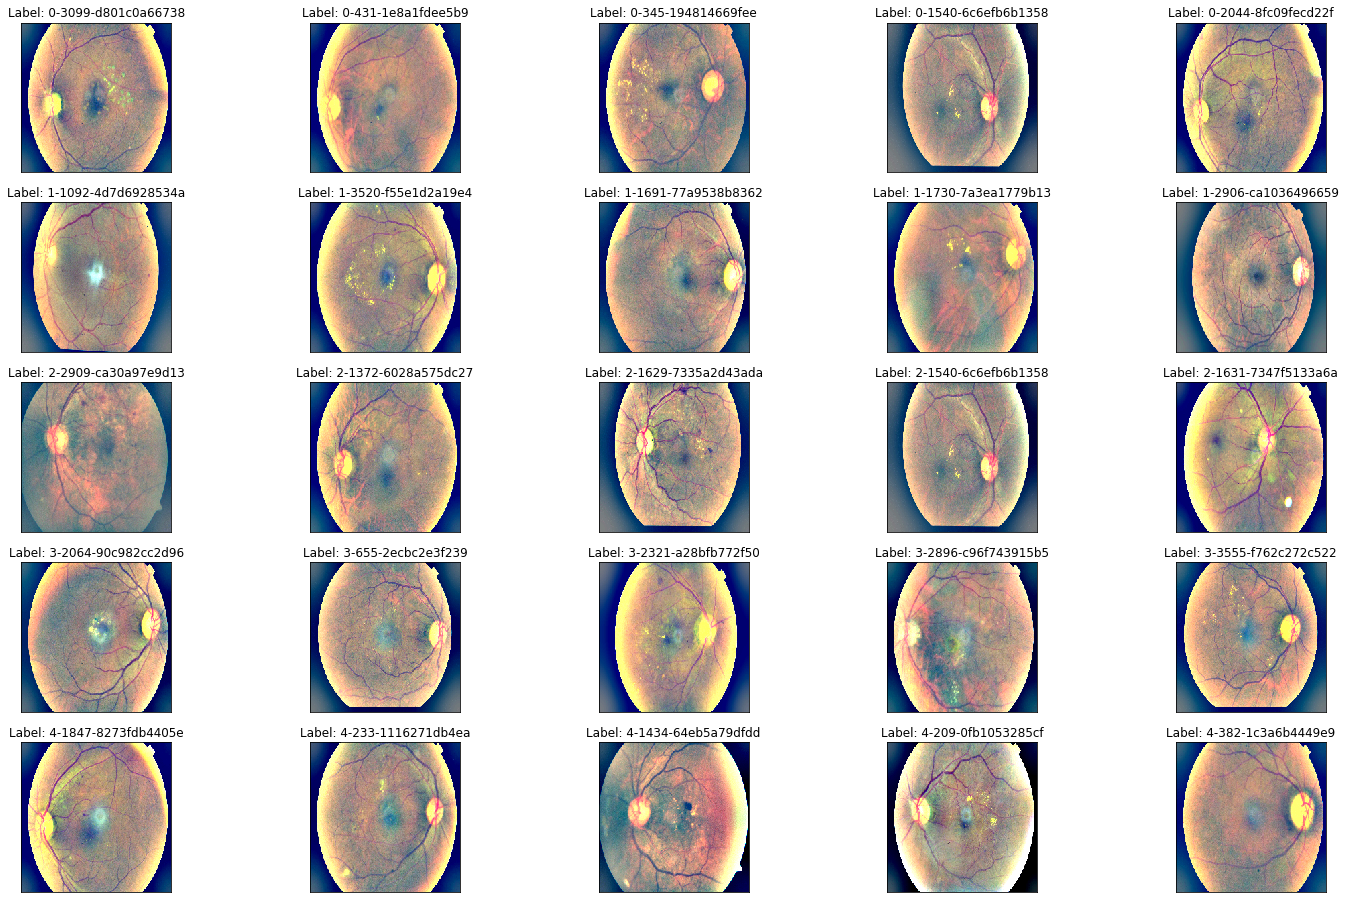

In [ ]:
y_train.hist()
IMG_SIZE=224
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(train.loc[train['diagnosis'] == 1].sample(5).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path = os.path.join('./drive/My Drive/Colab Notebooks/train_images', train.loc[idx,'id_code'] + '.png')
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line
        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

#7.
#data augmentation using random horizontal flip

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

데이터를 늘리기 위해 랜덤으로 이미지를 좌우반전을 한다.

이미지를 텐서로 변형한다.





#8.
#importing vgg19 model

In [ ]:
from torchvision.models import vgg19
VGG19 = torchvision.models.vgg19(pretrained = True)

#9. 
#splitting the train data set into train set and validation set

In [ ]:
Dataset = RetinopathyData(csv_file='./drive/My Drive/Colab Notebooks/train.csv',transform = train_transform)
train_set, test_set = torch.utils.data.random_split(Dataset,[2929,733])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=0,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=True, num_workers=0,drop_last=True)
train_set[1]
# 둘의 차이점..


{'image': tensor([[[0.4706, 0.4706, 0.4706,  ..., 0.4863, 0.4863, 0.4863],
          [0.4706, 0.4706, 0.4706,  ..., 0.4863, 0.4863, 0.4863],
          [0.4706, 0.4706, 0.4706,  ..., 0.4863, 0.4863, 0.4863],
          ...,
          [0.4863, 0.4863, 0.4863,  ..., 0.5020, 0.5020, 0.5020],
          [0.4863, 0.4863, 0.4863,  ..., 0.5020, 0.5020, 0.5020],
          [0.4863, 0.4863, 0.4863,  ..., 0.5020, 0.5020, 0.4863]],
 
         [[0.2980, 0.2824, 0.2824,  ..., 0.3922, 0.3922, 0.3922],
          [0.2980, 0.2824, 0.2824,  ..., 0.3922, 0.3922, 0.3922],
          [0.2824, 0.2824, 0.2824,  ..., 0.3922, 0.3922, 0.3922],
          ...,
          [0.3765, 0.3765, 0.3765,  ..., 0.4392, 0.4235, 0.4235],
          [0.3765, 0.3765, 0.3765,  ..., 0.4392, 0.4235, 0.4235],
          [0.3765, 0.3765, 0.3765,  ..., 0.4392, 0.4392, 0.4078]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2667, 0.2667],
          [0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2667, 0.2667],
          [0.0000, 0.0000, 0.00

#10.
#constructing the model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG19.to(device)
learning_rate = 0.001
num_epoch = 4
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)
device

device(type='cuda', index=0)

vgg를 모델로 사용하여 ADAM 으로 optimize함.

#11.
#traning loop

In [ ]:
loss_arr = []
# tk0 = tqdm(train_loader, total=int(len(train_loader)))
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,batch in enumerate(train_loader):
        x = batch['image'].to(device)
        y_ = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model.forward(x) 
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())
            

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(13.6272, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.4575, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1698, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.3718, device='cuda:0', grad_fn=<NllLossBackward>)


epoch 수만큼 반복하여 학습시킴. 

#12.
#evaluating the model

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for b,di in enumerate(test_loader):
        x = di['image'].to(device)
        y_ = di['labels'].to(device)
        
        output = model.forward(x)
        _,output_index = torch.max(output,1)
        
        total += y_.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 52.840911865234375
